# Hypothesis Testing in Healthcare: Drug Safety

A pharmaceutical company GlobalXYZ has just completed a randomized controlled drug trial. To promote transparency and reproducibility of the drug's outcome, they (GlobalXYZ) have presented the dataset to your organization, a non-profit that focuses primarily on drug safety.

The dataset provided contained five adverse effects, demographic data, vital signs, etc. Your organization is primarily interested in the drug's adverse reactions. It wants to know if the adverse reactions, if any, are of significant proportions. It has asked you to explore and answer some questions from the data.

The dataset `drug_safety.csv` was obtained from [Hbiostat](https://hbiostat.org/data/) courtesy of the Vanderbilt University Department of Biostatistics. It contained five adverse effects: headache, abdominal pain, dyspepsia, upper respiratory infection, chronic obstructive airway disease (COAD), demographic data, vital signs, lab measures, etc. The ratio of drug observations to placebo observations is 2 to 1.

For this project, the dataset has been modified to reflect the presence and absence of adverse effects `adverse_effects` and the number of adverse effects in a single individual `num_effects`.

The columns in the modified dataset are: 

| Column | Description |
|--------|-------------|
|`sex` | The gender of the individual |
|`age` | The age of the individual |
|`week` | The week of the drug testing |
|`trx` | The treatment (Drug) and control (Placebo) groups | 
|`wbc` | The count of white blood cells |
|`rbc` | The count of red blood cells |
|`adverse_effects` | The presence of at least a single adverse effect |
|`num_effects` | The number of adverse effects experienced by a single individual |

The original dataset can be found [here](https://hbiostat.org/data/repo/safety.rda).

Your organization has asked you to explore and answer some questions from the data collected. See the project instructions.

In [1]:
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
import pingouin
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
drug_safety = pd.read_csv("drug_safety.csv")
drug_safety.head()

,age,sex,trx,week,wbc,rbc,adverse_effects,num_effects
0,62,male,Drug,0,7.3,5.1,No,0
1,62,male,Drug,1,NaN,NaN,No,0
2,62,male,Drug,12,5.6,5.0,No,0
3,62,male,Drug,16,NaN,NaN,No,0
4,62,male,Drug,2,6.6,5.1,No,0


In [2]:
# Count the adverse_effects column values for each trx group
adv_eff_by_trx = drug_safety.groupby("trx").adverse_effects.value_counts()
adv_eff_by_trx

trx      adverse_effects
Drug     No                 9703
         Yes                1024
Placebo  No                 4864
         Yes                 512
Name: adverse_effects, dtype: int64

In [3]:
# Compute total rows in each group
adv_eff_by_trx_totals = adv_eff_by_trx.groupby("trx").sum()
adv_eff_by_trx_totals

trx
Drug       10727
Placebo     5376
Name: adverse_effects, dtype: int64

In [4]:
# Create an array of the "Yes" counts for each group
yeses = [adv_eff_by_trx["Drug"]["Yes"], adv_eff_by_trx["Placebo"]["Yes"]]

# Create an array of the total number of rows in each group
n = [adv_eff_by_trx_totals["Drug"], adv_eff_by_trx_totals["Placebo"]]

# comparing the proportions of "Yes" responses between two groups (possibly "Drug" and "Placebo") using a two-sample z-test for proportions., two-sided for default
two_sample_results = proportions_ztest(yeses, n)
two_sample_results

(0.0452182684494942, 0.9639333330262475)

In [5]:
# Store the p-value
two_sample_p_value = two_sample_results[1]

In [6]:
# Determine if num_effects and trx are independent
num_effects_groups = pingouin.chi2_independence(
    data=drug_safety, x="num_effects", y="trx")
num_effects_groups

(trx                 Drug      Placebo
 num_effects                          
 0            9703.794883  4863.205117
 1             960.587096   481.412904
 2              58.621126    29.378874
 3               3.996895     2.003105,
 trx          Drug  Placebo
 num_effects               
 0            9703     4864
 1             956      486
 2              63       25
 3               5        1,
                  test    lambda      chi2  dof      pval    cramer     power
 0             pearson  1.000000  1.799644  3.0  0.615012  0.010572  0.176275
 1        cressie-read  0.666667  1.836006  3.0  0.607131  0.010678  0.179153
 2      log-likelihood  0.000000  1.922495  3.0  0.588648  0.010926  0.186033
 3       freeman-tukey -0.500000  2.001752  3.0  0.572043  0.011149  0.192379
 4  mod-log-likelihood -1.000000  2.096158  3.0  0.552690  0.011409  0.199984
 5              neyman -2.000000  2.344303  3.0  0.504087  0.012066  0.220189)

In [7]:
# # Extract the p-value
num_effects_p_value = num_effects_groups[2]["pval"][0]

In [8]:
# Optionally - confirm the histogram's output by conducting a normality test
# To choose between unpaired t-test and Wilcoxon-Mann-Whitney test
normality = pingouin.normality(
    data=drug_safety,
    dv='age',
    group='trx',
    method='shapiro', # the default
    alpha=0.05) # 0.05 is also the default
normality

,W,pval,normal
trx,,,
Drug,0.976785,2.189152e-38,False
Placebo,0.975595,2.224950e-29,False


<AxesSubplot: xlabel='age', ylabel='Count'>

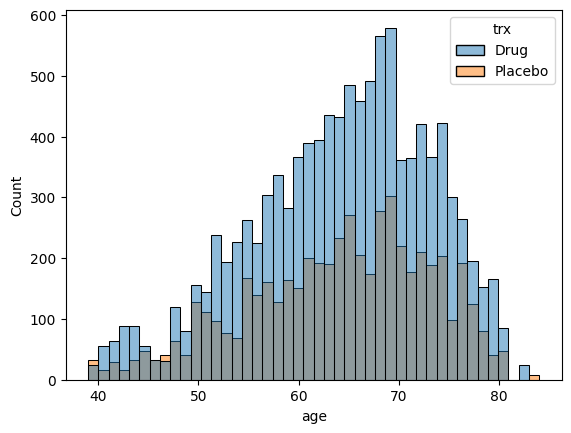

In [9]:
sns.histplot(data=drug_safety, x="age", hue="trx")

In [10]:
# Create two variables for age, one for each treatment group
age_trx = drug_safety.loc[drug_safety['trx'] == 'Drug', 'age']
age_placebo = drug_safety.loc[drug_safety['trx'] == 'Placebo', 'age']

# Perform Mann-Whitney U test
result = pingouin.mwu(age_trx, age_placebo)

# Extract the p-value from the result DataFrame
age_group_effects_p_value = result['p-val'].values[0]
age_group_effects_p_value

0.25696267004066287

<AxesSubplot: xlabel='trx'>

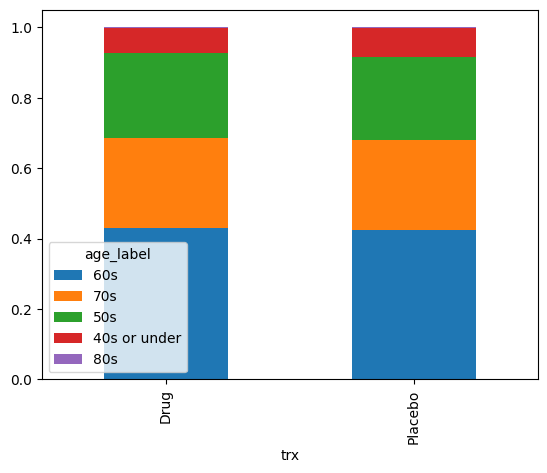

In [11]:
drug_safety['age_label']=pd.cut(drug_safety['age'],bins=list(range(40, 91, 10)),labels=['40s or under','50s','60s','70s','80s'])
adv_eff_by_trx = drug_safety.groupby("trx")['age_label'].value_counts(normalize=True)
adv_eff_by_trx = adv_eff_by_trx.unstack()
adv_eff_by_trx.plot(kind='bar',stacked=True)